<a href="https://colab.research.google.com/github/wockeshuh/CSCI166/blob/main/CSCI166Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Project

By: Freddy Barrita, Jobnane Moreno, and Alvaro Lopez


#Objective
- This project applies reinforcement learning techniques to solve the FrozenLake, CartPole, and LunarLander environments, illustrating a progression from foundational to advanced methods. Q-Learning was employed for the discrete grid-based FrozenLake environment, Approximate Q-Learning addressed the continuous state space of CartPole, and Deep Q-Learning was used for LunarLander. Through performance analysis, we examined learning curves, convergence patterns, and areas for improvement.

## Tools and Algorithms Used to Develop the Solution
 - Libraries:
- Gymnasium: for reinforcement learning environments
- NumPy: for numerical computations and data manipulation
- Matplotlib: for visualizations
- PyTorch: implements deep learning models for tasks
- Collections: to manage data structures
- Random: supports random sampling for exploration and replay buffer sampling

In [10]:
!pip install gymnasium
!pip install torch
!pip install swig
!pip install 'gymnasium[box2d]'
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

## Q-Learning Implementation
**Environment:** FrozenLake
#####**Domain Description:**
- State space: Top left corner of the 4x4 grid.
- Action space: 4 actions (up, down, left, right).
- Reward structure: +1 for reaching the goal, 0 otherwise.
- Goal: Navigate from start to goal without falling into a hole.


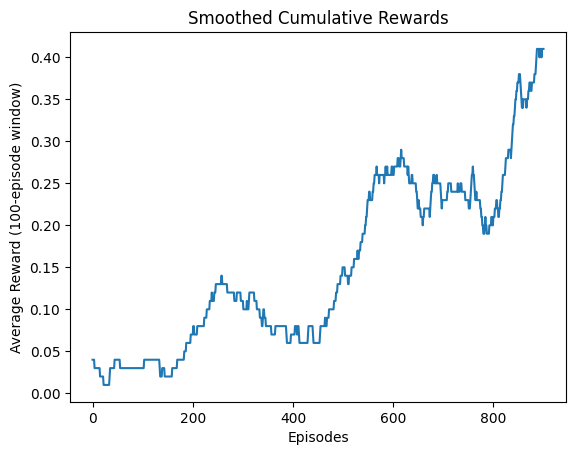

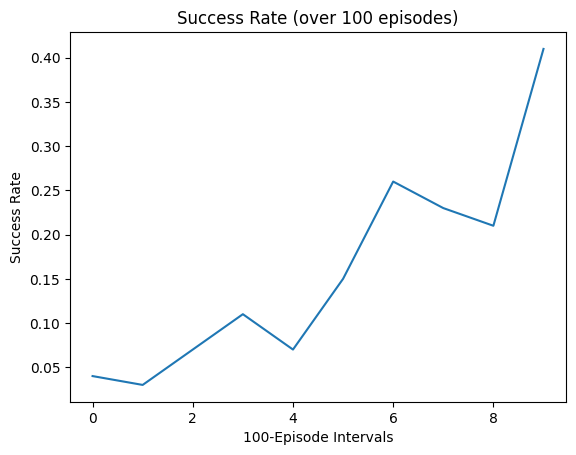

The problem was solved in 158 episodes.
Average number of steps to solve: 24.97


In [ ]:
env = gym.make("FrozenLake-v1")

def q_learning(env, gamma=0.9, alpha=0.4, epsilon=1.0, epsilon_min=0.01, decay_rate=0.004, num_episodes=1000):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    rewards = []
    steps_to_solve = []
    success_rate = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            # epsilon-Greedy action selection with decayed epsilon
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            # take action and observe next state and reward
            next_state, reward, done, _, _ = env.step(action)

            # q-learning update (Bellman equation)
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

            total_reward += reward
            steps += 1
            state = next_state

        # track rewards and steps
        rewards.append(total_reward)
        if total_reward > 0:  # successful episode
            steps_to_solve.append(steps)

        # update success rate
        if (episode + 1) % 100 == 0:
            success_rate.append(sum(rewards[-100:]) / 100)

        # apply epsilon decay
        epsilon = max(epsilon_min, epsilon * np.exp(-decay_rate))

    return Q, rewards, steps_to_solve, success_rate

# train the agent with epsilon decay
Q, rewards, steps_to_solve, success_rate = q_learning(env)

# learning curve
plt.figure()
plt.plot(np.convolve(rewards, np.ones(100)/100, mode='valid'))
plt.title('Smoothed Cumulative Rewards')
plt.xlabel('Episodes')
plt.ylabel('Average Reward (100-episode window)')
plt.show()

# success rate
plt.figure()
plt.plot(success_rate)
plt.title('Success Rate (over 100 episodes)')
plt.xlabel('100-Episode Intervals')
plt.ylabel('Success Rate')
plt.show()

# steps to solve the problem
if steps_to_solve:
    print(f"The problem was solved in {len(steps_to_solve)} episodes.")
    print(f"Average number of steps to solve: {np.mean(steps_to_solve):.2f}")
else:
    print("The problem was not solved in the given episodes.")

## Approximate Q-Learning Implementation
**Environment:** CartPole

#####**Domain Description:**
- State space: Continuous (cart position, cart velocity, pole angle, pole angular velocity).
- Action space: 2 actions (push left, push right).
- Reward structure: +1 for every timestep pole remains upright.
- Goal: Balance the pole as long as possible.



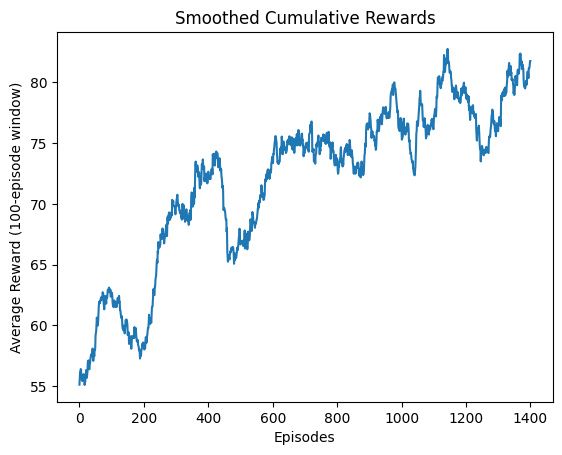

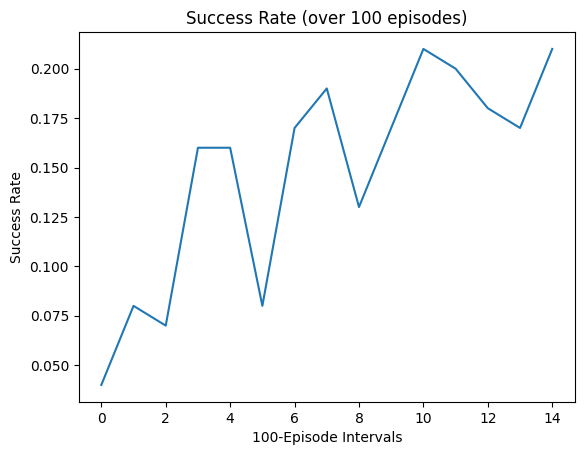

The problem was solved in 222 episodes.
Average number of steps to solve: 125.03


In [9]:
env = gym.make('CartPole-v1')

class LinearApproximator:
    def __init__(self, state_dim, action_dim, learning_rate):
        self.weights = np.zeros((state_dim, action_dim))
        self.lr = learning_rate

    def predict(self, state):
        return np.dot(state, self.weights)

    def update(self, state, action, td_error, eligibility):
        self.weights += self.lr * td_error * eligibility

# hyperparameters
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
learning_rate = 0.005
discount_factor = 0.99
lambda_param = 1.0
epsilon = 0.5
epsilon_decay = 0.9990
epsilon_min = 0.01
num_episodes = 1500
reward_threshold = 100
reward_shaping_angle = 0.05
reward_shaping_position = 0.005
window_size = 100

model = LinearApproximator(state_dim, action_dim, learning_rate)

# training
rewards = []
steps_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = np.array(state).flatten()
    state = (state - np.mean(state)) / (np.std(state) + 1e-5)
    total_reward = 0
    done = False
    eligibility = np.zeros_like(model.weights)
    steps = 0

    while not done:
        # epsilon-greedy policy
        if np.random.random() < epsilon:  # explore
            action = env.action_space.sample()
        else:  # exploit
            q_values = model.predict(state)
            action = np.argmax(q_values)

        # take action
        next_state, reward, done, truncated, _ = env.step(action)

        # reward shaping: penalize deviations from stability
        pole_angle, cart_position = next_state[2], next_state[0]
        reward -= abs(pole_angle) * reward_shaping_angle + abs(cart_position) * reward_shaping_position

        # compute TD error
        td_target = reward + discount_factor * np.max(model.predict(next_state)) * (not done)
        td_error = td_target - model.predict(state)[action]

        # update eligibility traces
        eligibility *= discount_factor * lambda_param
        eligibility[:, action] += state

        # update weights
        model.update(state, action, td_error, eligibility)

        steps += 1

        state = next_state
        total_reward += reward
        done = done or truncated

    rewards.append(total_reward)
    steps_per_episode.append(steps)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)


# calculate smoothed rewards
smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')

# calculate success rates over windows
success_rates = [
    np.mean([1 if r >= reward_threshold else 0 for r in rewards[i:i+window_size]])
    for i in range(0, len(rewards), window_size)
]
solved_episodes = [steps for steps, reward in zip(steps_per_episode, rewards) if reward >= reward_threshold]


plt.figure()
plt.plot(smoothed_rewards)
plt.title('Smoothed Cumulative Rewards')
plt.xlabel('Episodes')
plt.ylabel(f'Average Reward ({window_size}-episode window)')
plt.show()

plt.figure()
plt.plot(success_rates)
plt.title(f'Success Rate (over {window_size} episodes)')
plt.xlabel(f'{window_size}-Episode Intervals')
plt.ylabel('Success Rate')
plt.show()

if solved_episodes:
    print(f"The problem was solved in {len(solved_episodes)} episodes.")
    print(f"Average number of steps to solve: {np.mean(solved_episodes):.2f}")
else:
    print("The problem was not solved in the given episodes.")


## Deep Q-Learning Implementation
**Environment:** LunarLander

#####**Domain Description:**
- State space: Continuous (position(x,y), velocity(vx, vy), angle, angular velocity, leg contacts).
- Action space: 4 actions (do nothing, fire main engine, fire left engine, fire right engine).
- Reward structure: Points for landing successfully and penalties for crashing.
- Goal: Land the spacecraft safely.


Episode 0, Reward: -23.105198749387853, Steps: 91
Episode 100, Reward: -248.47997680409313, Steps: 250
Episode 200, Reward: 237.77173406354086, Steps: 964
Episode 300, Reward: -48.41589732321949, Steps: 233
Episode 400, Reward: 16.463833843715506, Steps: 233


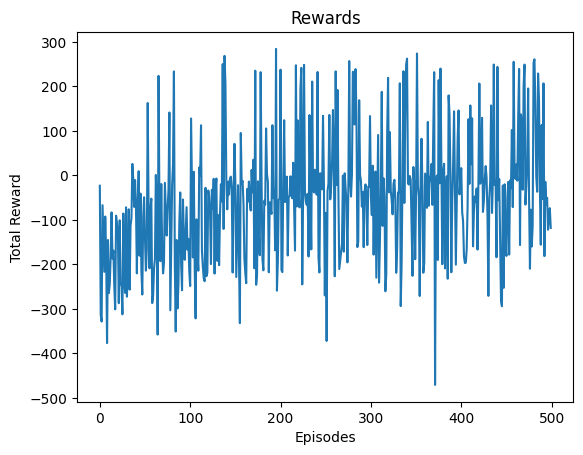

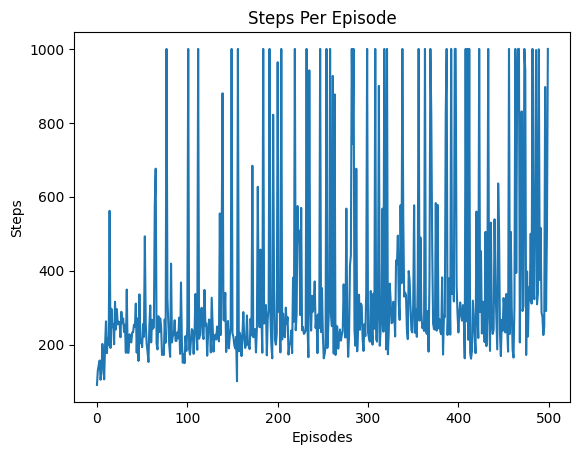

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


env = gym.make('LunarLander-v3')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n


# hyperparameters
learning_rate = 0.001
discount_factor = 0.99
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
batch_size = 64
replay_buffer_size = 100000
tau = 0.01
num_episodes = 500
max_steps_per_episode = 1000
reward_threshold = 100


class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.alpha = alpha
        self.pos = 0

    def add(self, transition, td_error):
        priority = (abs(td_error) + 1e-5) ** self.alpha
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(priority)
        else:
            self.buffer[self.pos] = transition
            self.priorities[self.pos] = priority
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size):
        probabilities = np.array(self.priorities) ** self.alpha
        probabilities /= probabilities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        transitions = [self.buffer[i] for i in indices]
        return transitions

    def update_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = (abs(td_error) + 1e-5) ** self.alpha


# initialize networks, optimizers, and replay buffer
policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = PrioritizedReplayBuffer(replay_buffer_size)

def train():
    if len(replay_buffer.buffer) < batch_size:
        return

    transitions = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*transitions)

    states = torch.FloatTensor(np.array(states))
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(np.array(next_states))
    dones = torch.FloatTensor(dones).unsqueeze(1)

    q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1, keepdim=True)[0]
    targets = rewards + discount_factor * next_q_values * (1 - dones)

    td_errors = targets - q_values
    loss = nn.HuberLoss()(q_values, targets.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return td_errors.squeeze().detach().cpu().numpy()

def soft_update():
    for target_param, policy_param in zip(target_net.parameters(), policy_net.parameters()):
        target_param.data.copy_(tau * policy_param.data + (1 - tau) * target_param.data)


rewards_per_episode = []
steps_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    steps = 0

    for step in range(max_steps_per_episode):
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(policy_net(torch.FloatTensor(state))).item()

        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        steps += 1

        td_error = reward + discount_factor * target_net(torch.FloatTensor(next_state)).max().item() - policy_net(torch.FloatTensor(state))[action].item()
        replay_buffer.add((state, action, reward, next_state, done), td_error)

        state = next_state
        if done:
            break

        td_errors = train()
        if td_errors is not None:
            replay_buffer.update_priorities(range(len(td_errors)), td_errors)

    soft_update()
    rewards_per_episode.append(total_reward)
    steps_per_episode.append(steps)

    if episode % 100 == 0:
        print(f"Episode {episode}, Reward: {total_reward}, Steps: {steps}")

# plot Results
plt.plot(rewards_per_episode)
plt.title('Rewards')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

plt.plot(steps_per_episode)
plt.title('Steps Per Episode')
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.show()